# ЭТАП 3. ОТБОР ЗНАЧИМЫХ ПРИЗНАКОВ С ПОМОЩЬЮ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ

В этой части КП мы обучим модель логистической регрессии на различных вариантах обучающей выборки с целью отбора наиболее значимых признаков. Для этого здесь будет использоваться L1-регуляризация. Также рассмотрим влияние незначительного шума на точность итоговых моделей

In [2]:
import pandas as pd, dill
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
#функция добавления шума в вещественные признаки

def add_noi(x,scale=1.0,two_side=True):
    '''
    Добавление шума в 1D-массив x.
    
    scale - размах значений (равномерное распределение)
    two_side - двусторонность (как вычитание, так и прибавление шума при two_side=True),
    в противном случае только прибавление
    '''
    if two_side:
        noi = np.random.rand(np.shape(x)[0],)*scale - 0.5*scale
    else:
        noi = np.random.rand(np.shape(x)[0],)*scale
    
    return x + noi

In [4]:
#загрузим данные, полученные на предыдущем шаге
data_train = pd.read_csv('data_train_all.csv')

data_train

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,235,236,237,238,239,240,241,242,243,244
0,1631111,7.0,1544994000,0.0,4.675076,-0.020189,-0.468545,1.596964,-0.095832,-0.095207,...,0.090413,0.037193,-0.026843,0.646390,-0.035110,1.491440,1.467026,-0.096850,-0.004824,1.0
1,832134,1.0,1533502800,0.0,-0.153991,-0.020189,0.147436,-0.069840,-0.095832,-0.095207,...,-0.075456,1.105312,-0.026843,-0.867375,-0.035110,-0.665829,-0.262893,0.520399,-0.004824,1.0
2,1232915,2.0,1546203600,0.0,1.869464,-0.020189,1.611682,0.892972,-0.095832,-0.095207,...,-0.075456,0.728329,-0.026843,-0.044677,-0.035110,-0.665829,-0.213466,-0.096850,-0.004824,0.0
3,1564770,1.0,1541365200,0.0,-0.153991,-0.020189,-0.487755,-0.121604,-0.095832,-0.095207,...,-0.069312,-0.999510,-0.026843,1.172917,-0.035110,1.502977,0.330222,-0.096850,-0.004824,1.0
4,3769599,5.0,1540760400,0.0,-0.153991,-0.020189,1.380406,-0.276896,-0.095832,-0.095207,...,-0.075456,-0.999510,-0.026843,-0.801560,-0.035110,-0.665829,-0.262893,-0.096850,-0.004824,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38910,157710,7.0,1542574800,1.0,-0.158626,-0.016475,-0.178166,-0.611968,-0.085067,-0.101450,...,-0.115705,-0.937132,-0.023645,1.861228,-0.036137,-0.466078,0.604400,-0.095878,-0.014732,0.0
38911,1780878,2.0,1545598800,0.0,-0.158626,-0.016475,-0.472100,-0.387723,-0.085067,-0.101450,...,-0.115705,0.618364,-0.023645,-1.289099,-0.036137,-0.466078,-0.234859,-0.095878,-0.014732,0.0
38912,608190,2.0,1545598800,0.0,-0.158626,-0.016475,-0.186218,-0.122706,-0.085067,-0.101450,...,-0.115705,-0.937132,-0.023645,-1.289099,-0.036137,-0.466078,-0.234859,-0.095878,-0.014732,0.0
38913,1913180,2.0,1544994000,0.0,0.400995,-0.016475,-0.472100,-0.245022,-0.085067,-0.101450,...,-0.115705,-0.937132,-0.023645,0.922833,-0.036137,2.161566,0.044894,-0.095878,-0.014732,1.0


In [5]:
#приведем тип услуги к dummy-виду:
vas_id_train = pd.get_dummies(data_train.vas_id)

#добавляем dummy-данные о типах предложений в выборки
data_train = data_train[list(data_train.columns)[3:]]
data_train = pd.concat((data_train,vas_id_train),axis=1)

data_train

,target,0,1,2,3,4,5,6,7,8,...,243,244,1.0,2.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0.0,4.675076,-0.020189,-0.468545,1.596964,-0.095832,-0.095207,-0.009710,0.634649,-0.025584,...,-0.004824,1.0,0,0,0,0,0,1,0,0
1,0.0,-0.153991,-0.020189,0.147436,-0.069840,-0.095832,-0.095207,-0.009710,-0.169023,-0.025584,...,-0.004824,1.0,1,0,0,0,0,0,0,0
2,0.0,1.869464,-0.020189,1.611682,0.892972,-0.095832,-0.095207,-0.009710,-0.169023,-0.025584,...,-0.004824,0.0,0,1,0,0,0,0,0,0
3,0.0,-0.153991,-0.020189,-0.487755,-0.121604,-0.095832,-0.095207,-0.009710,-0.169023,-0.025584,...,-0.004824,1.0,1,0,0,0,0,0,0,0
4,0.0,-0.153991,-0.020189,1.380406,-0.276896,-0.095832,-0.095207,-0.009710,-0.169023,-0.025584,...,-0.004824,1.0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38910,1.0,-0.158626,-0.016475,-0.178166,-0.611968,-0.085067,-0.101450,-0.010995,-0.177435,-0.033052,...,-0.014732,0.0,0,0,0,0,0,1,0,0
38911,0.0,-0.158626,-0.016475,-0.472100,-0.387723,-0.085067,-0.101450,-0.010995,-0.177435,-0.033052,...,-0.014732,0.0,0,1,0,0,0,0,0,0
38912,0.0,-0.158626,-0.016475,-0.186218,-0.122706,-0.085067,-0.101450,-0.010995,-0.177435,-0.033052,...,-0.014732,0.0,0,1,0,0,0,0,0,0
38913,0.0,0.400995,-0.016475,-0.472100,-0.245022,-0.085067,-0.101450,-0.010995,-0.177435,-0.033052,...,-0.014732,1.0,0,1,0,0,0,0,0,0


<AxesSubplot:>

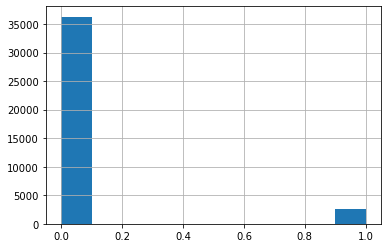

In [6]:
#посмотрим на распределение целевой переменной
data_train.target.hist()

In [7]:
#Наблюдается явный дисбаланс классов в целевой переменной. Поэтому продублируем части выборки, относящиеся к классу 1, 14 раз:
36273/2642

13.729371688115064

Создадим 2 версии выборки: в первой версии будем просто дублировать части выборки, относящиеся к классу 1, а во второй версии к каждой части, начиная со второй, мы будем добавлять шум к вещественным колонкам

In [8]:
data_train_1 = data_train.loc[data_train.target==1]
data_train_v1 = deepcopy(data_train)
data_train_v2 = deepcopy(data_train)
del data_train

#версия 1
for i in range(14):
    data_train_v1 = pd.concat((data_train_v1,data_train_1),axis=0)

#версия 2
for i in range(14):
    if i==0:
        data_train_v2 = pd.concat((data_train_v2,data_train_1),axis=0)
    else:
        data_train_1_c = deepcopy(data_train_1)
        data_train_1_cols = list(data_train_1.columns)[1:245] #непрерывные признаки
        data_train_1_c[data_train_1_cols] = data_train_1_c[data_train_1_cols].apply(add_noi,scale=0.0002) #шум с разбросом [-0.0001;0.0001]
        data_train_v2 = pd.concat((data_train_v2,data_train_1_c),axis=0)

(75903, 254)
(75903, 254)


<AxesSubplot:>

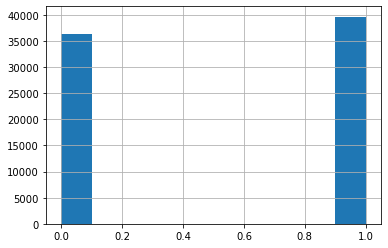

In [10]:
print(data_train_v1.shape)
print(data_train_v2.shape)

#смотрим теперь на распределение целевой переменной
data_train_v1.target.hist()

Класс

## 3.1. Создание модели машинного обучения; обучение на обеих версиях выборки, выбор лучшей выборки

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve

#Перемешаем выборки:
data_train_v1 = data_train_v1.sample(frac=1.0, ignore_index=True)
data_train_v2 = data_train_v2.sample(frac=1.0, ignore_index=True)

#возьмем 20% от всех выборок и обучим логистическую регрессию для отбора признаков:
data_train_v1_frac = data_train_v1.sample(frac=0.2, ignore_index=True)
data_train_v2_frac = data_train_v2.sample(frac=0.2, ignore_index=True)

#Разделим входные векторы и образцы:
X_v1 = data_train_v1_frac.drop('target', axis=1)
y_v1 = data_train_v1_frac.target
X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.2, random_state=42)

X_v2 = data_train_v2_frac.drop('target', axis=1)
y_v2 = data_train_v2_frac.target
X_v2_train, X_v2_test, y_v2_train, y_v2_test = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

print(X_v1_train.shape, X_v1_test.shape, y_v1_train.shape, y_v1_test.shape)
print(X_v2_train.shape, X_v2_test.shape, y_v2_train.shape, y_v2_test.shape)

(12144, 253) (3037, 253) (12144,) (3037,)
(12144, 253) (3037, 253) (12144,) (3037,)


Обучим модель на частичной выборке (однократно), определим наиболее важные признаки для каждой из выборок, а также определим, на какой из выборок результаты будут выше

In [12]:
#ВЕРСИЯ 1
model = LogisticRegression(penalty='l1', max_iter=100, C=1.0, solver='liblinear')
model.fit(X_v1_train,y_v1_train)
y_v1_pred = model.predict_proba(X_v1_test)

#МЕТРИКИ
v1_roc = roc_curve(y_v1_test,y_v1_pred[:,1])
v1_pr_p, v1_pr_r, v1_pr_t = precision_recall_curve(y_v1_test,y_v1_pred[:,1])
v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)

#извлечем коэффициенты значимости признаков и отсортируем их:
model_coef_v1 = np.squeeze(model.coef_.T,axis=1)
model_coef_v1 = pd.Series(model_coef_v1,index=list(X_v1.columns))
model_coef_v1 = model_coef_v1.sort_values(ascending=False)

In [13]:
#ВЕРСИЯ 2
model = LogisticRegression(penalty='l1', max_iter=100, C=1.0, solver='liblinear')
model.fit(X_v2_train,y_v2_train)
y_v2_pred = model.predict_proba(X_v2_test)

#МЕТРИКИ
v2_roc = roc_curve(y_v2_test,y_v2_pred[:,1])
v2_pr_p, v2_pr_r, v2_pr_t = precision_recall_curve(y_v2_test,y_v2_pred[:,1])
v2_F = 2*(v2_pr_p*v2_pr_r)/(v2_pr_p+v2_pr_r)

#извлечем коэффициенты значимости признаков и отсортируем их:
model_coef_v2 = np.squeeze(model.coef_.T,axis=1)
model_coef_v2 = pd.Series(model_coef_v2,index=list(X_v2.columns))
model_coef_v2 = model_coef_v2.sort_values(ascending=False)

<ipython-input-13-dedbc40d4a58>:9: RuntimeWarning: invalid value encountered in true_divide
  v2_F = 2*(v2_pr_p*v2_pr_r)/(v2_pr_p+v2_pr_r)


Максимальное значение F-меры на выборках:
версия 1: 0.8792569659442725,
версия 2: 0.8679245283018868


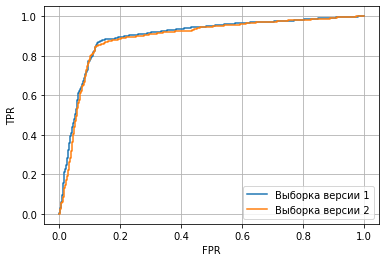

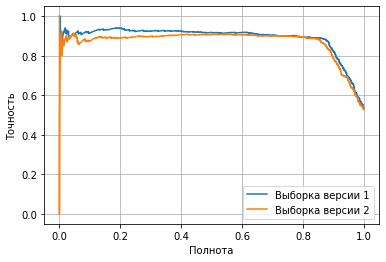

In [14]:
#чертим графики ROC-AUC и PR-кривых
plt.figure()
plt.plot(v1_roc[0],v1_roc[1])
plt.plot(v2_roc[0],v2_roc[1])
plt.legend(['Выборка версии 1', 'Выборка версии 2'])
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.figure()
plt.plot(v1_pr_r,v1_pr_p)
plt.plot(v2_pr_r,v2_pr_p)
plt.legend(['Выборка версии 1', 'Выборка версии 2'])
plt.grid()
plt.xlabel('Полнота')
plt.ylabel('Точность')

print('Максимальное значение F-меры на выборках:\nверсия 1: {},\nверсия 2: {}'.format(max(v1_F),max(v2_F)))

На второй версии выборки модель показала меньшее значение F-меры. Поэтому будем дальше работать с первой версией выборки (без добавления шума).

Теперь отберем первые 50,49,48...10 признаков на первой выборке и обучим модель заново. Как сильно упадет значение F-меры с уменьшением кол-ва признаков?

<ipython-input-16-c93481c42cdf>:11: RuntimeWarning: invalid value encountered in true_divide
  v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
<ipython-input-16-c93481c42cdf>:11: RuntimeWarning: invalid value encountered in true_divide
  v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
<ipython-input-16-c93481c42cdf>:11: RuntimeWarning: invalid value encountered in true_divide
  v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
<ipython-input-16-c93481c42cdf>:11: RuntimeWarning: invalid value encountered in true_divide
  v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
<ipython-input-16-c93481c42cdf>:11: RuntimeWarning: invalid value encountered in true_divide
  v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
<ipython-input-16-c93481c42cdf>:11: RuntimeWarning: invalid value encountered in true_divide
  v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
<ipython-input-16-c93481c42cdf>:11: RuntimeWarning: invalid value encountered in true_divide
  v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
<ipython-input-16-c9

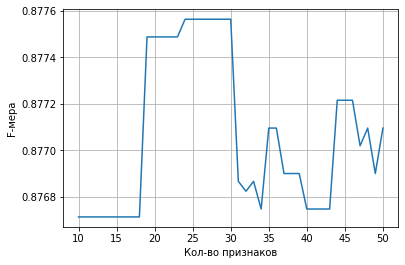

In [16]:
v1_F_vals=[]
for i in range(50,9,-1):
    model_coef_v1_topN = list(model_coef_v1[:i].index)
    model = LogisticRegression(penalty='l1', max_iter=100, C=1.0, solver='liblinear')
    model.fit(X_v1_train[model_coef_v1_topN],y_v1_train)
    y_v1_pred = model.predict_proba(X_v1_test[model_coef_v1_topN])
    
    #МЕТРИКИ
    v1_roc = roc_curve(y_v1_test,y_v1_pred[:,1])
    v1_pr_p, v1_pr_r, v1_pr_t = precision_recall_curve(y_v1_test,y_v1_pred[:,1])
    v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
    
    v1_F_vals.append(max(v1_F))

plt.figure()
plt.plot(np.arange(50,9,-1),v1_F_vals)
plt.xlabel('Кол-во признаков')
plt.ylabel('F-мера')
plt.grid()

Результаты ухудшились незначительно (примерно на 0,25% в худшем случае).

А если обучить все на полной выборке?

<ipython-input-17-2494efdc71a8>:15: RuntimeWarning: invalid value encountered in true_divide
  v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)


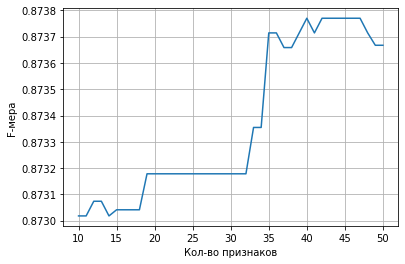

In [17]:
X_v1 = data_train_v1.drop('target', axis=1)
y_v1 = data_train_v1.target
X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.2, random_state=42)

v1_F_vals=[]
for i in range(50,9,-1):
    model_coef_v1_topN = list(model_coef_v1[:i].index)
    model = LogisticRegression(penalty='l1', max_iter=100, C=1.0, solver='liblinear')
    model.fit(X_v1_train[model_coef_v1_topN],y_v1_train)
    y_v1_pred = model.predict_proba(X_v1_test[model_coef_v1_topN])
    
    #МЕТРИКИ
    v1_roc = roc_curve(y_v1_test,y_v1_pred[:,1])
    v1_pr_p, v1_pr_r, v1_pr_t = precision_recall_curve(y_v1_test,y_v1_pred[:,1])
    v1_F = 2*(v1_pr_p*v1_pr_r)/(v1_pr_p+v1_pr_r)
    
    v1_F_vals.append(max(v1_F))

plt.figure()
plt.plot(np.arange(50,9,-1),v1_F_vals)
plt.xlabel('Кол-во признаков')
plt.ylabel('F-мера')
plt.grid()

Максимальные значения F-меры различаются незначительно. Поэтому можно взять и 10 признаков.

Сохраним top-10 признаков в файл для дальнейшего обучения различных моделей машинного обучения:

In [18]:
print(model_coef_v1_topN)

with open('top_10.dat','wb') as f:
    dill.dump(model_coef_v1_topN, f)

[6.0, 4.0, 9.0, '59', '221', '123', '37', '26', '194', '80']
